In [1]:
import Pkg
Pkg.activate(".")
Pkg.resolve()
Pkg.instantiate()
using DataFrames, CSV, Plots, CurveFit, Roots

  Activating project at `~/Documents/Still evolving/estimu`
  No Changes to `~/Documents/Still evolving/estimu/Project.toml`
  No Changes to `~/Documents/Still evolving/estimu/Manifest.toml`


## Estimated mutation rate increase is maximal for intermediate ciprofloxacin concentrations

In [2]:
MIC = 12
MAC = 8.5
df_Pribis = DataFrame(CSV.File("experimental_data/Pribis_Fig2D.txt"; comment="#"))

Row,cipro_concentration,number_experiments,no_cipro_mutation_rate,range_no,cipro_mutation_rate,range_cipro,fold_induction_mutation_rate,fold_min,fold_max,of_MIC
,Float64,Int64?,Float64,String15,Float64,String15,Float64,Float64,Float64,Float64
1,1.0,4,1.1,"(0.78,1.4)",1.7,"(1.2,2.2)",1.7,1.1,2.4,0.0833333
2,2.0,4,1.1,"(0.78,1.4)",2.3,"(2.0,2.6)",2.2,1.8,2.7,0.166667
3,4.0,4,1.1,"(0.78,1.4)",5.2,"(3.4,7.0)",4.8,4.2,5.3,0.333333
4,8.5,missing,0.62,"(0.51,0.75)",19.0,"(6,50)",30.0,11.0,67.0,0.708333
5,10.0,2,0.63,"(0.55,0.70)",10.0,"(10,11)",17.0,15.0,18.0,0.833333
6,12.0,9,1.2,"(0.92,1.4)",13.0,"(8.1,16)",11.0,7.1,15.0,1.0
7,14.0,2,0.63,"(0.55,0.70)",5.7,"(5.7,5.8)",9.3,8.3,10.0,1.16667


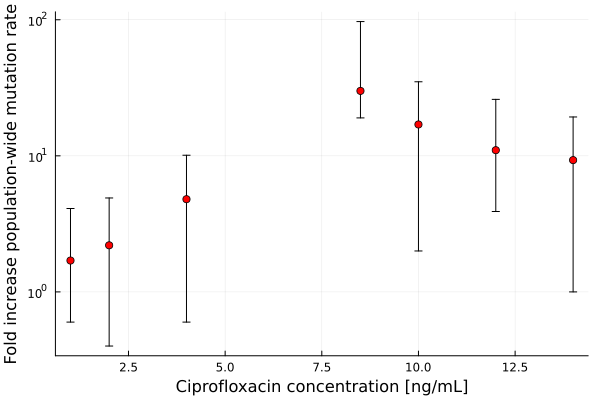

In [14]:
C = df_Pribis.cipro_concentration
M_MLE = df_Pribis.fold_induction_mutation_rate
M_lower = df_Pribis.fold_min
M_upper = df_Pribis.fold_max
P_M = plot(ylab="Fold increase population-wide mutation rate", xlab="Ciprofloxacin concentration [ng/mL]", yscale=:log10)
scatter!(C, M_MLE, yerror=(M_lower, M_upper), lab="", c=:red)

## Population dynamics with highly-mutating and slowly dividing subpopulation

In [6]:
# Population growth dynamics of non-mutants (deterministic)
# Growth of response-off subpopulation: exponential growth with population growth rate = division-death-switching rate, initial population size N0
pop_size(t, N0_off, pop_growth) = N0_off*exp(pop_growth*t)
# With carrying capacity (given by the final population size)
pop_size(t, N0_off, pop_growth, Nf) = Nf * N0_off * exp(pop_growth*t)/(Nf + N0_off*(exp(pop_growth*t)-1))
# Growth of response-on subpopulation: influx from response-off subpopulation plus exponential growth with own net growth rate = division-death rate, initial population size N0_on 
function pop_size(t, N0_off, pop_growth, switching, N0_on, net_growth_on)
    if net_growth_on == pop_growth
        return (N0_off*switching*t + N0_on) * exp(pop_growth*t)
    else
        return N0_off*switching/(pop_growth - net_growth_on) * (exp(pop_growth*t) - exp(net_growth_on*t)) + N0_on*exp(net_growth_on*t)
    end
end

pop_size (generic function with 2 methods)

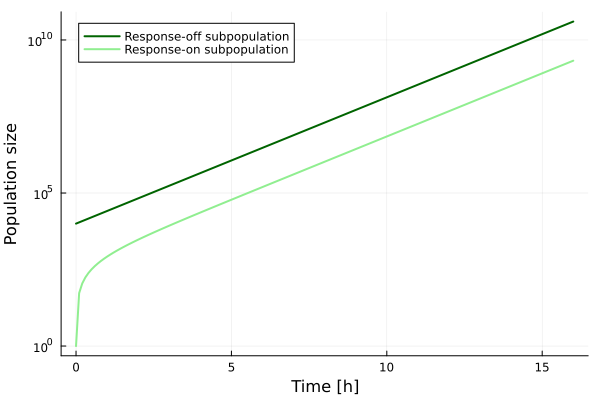

In [17]:
N0_off = 10^4
gamma_off = 1.
delta_off = 0.
switching = 0.05
N0_on = 1.
gamma_on_rel = 0.
delta_on = 0.
tf = 16
P_popdyn = plot(xlab="Time [h]", ylab="Population size", yscale=:log10, legend=:topleft)
plot!(0:0.1:tf, x -> pop_size(x, N0_off, gamma_off-delta_off-switching), lab="Response-off subpopulation", c=:darkgreen, width=2)
plot!(0:0.1:tf, x -> pop_size(x, N0_off, gamma_off-delta_off-switching, switching, N0_on, gamma_on_rel*gamma_off-delta_on), lab="Response-on subpopulation", c=:lightgreen, width=2)

### How do the population dynamics depend on the antibiotic concentration?

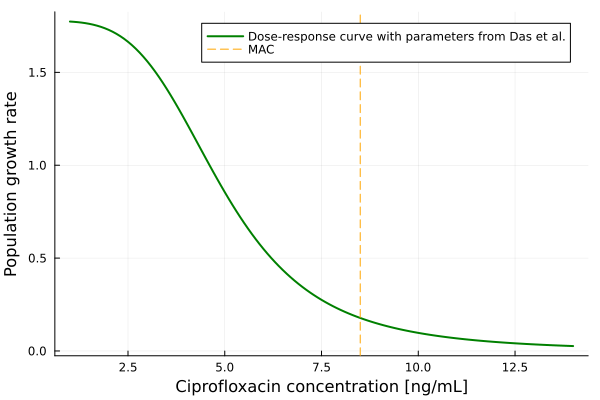

In [18]:
# Population growth rate depending on antibiotic concentration
growth_rate(lambda_max, c, IC50, hill_coeff) = lambda_max/(1+(c/IC50)^hill_coeff)
# Dose-reponse curve from Das et al.
hill_coeff = 4.
MAC_to_IC50(MAC, hill_coeff) = MAC/9^(1/hill_coeff)
IC50 = MAC_to_IC50(MAC, hill_coeff)
lambda_max = 1.7766242417013847
P_lambda = plot(xlab="Ciprofloxacin concentration [ng/mL]", ylab="Population growth rate")
plot!(minimum(C):0.1:maximum(C), x -> growth_rate(lambda_max, x, IC50, hill_coeff), lab="Dose-response curve with parameters from Das et al.", c=:green, width=2)
vline!([MAC], lab="MAC", style=:dash, c=:orange)

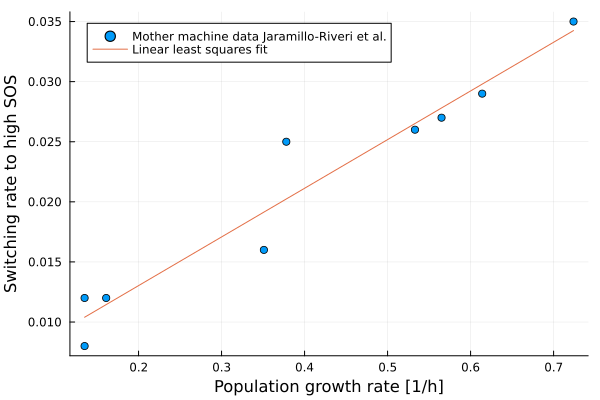

In [19]:
# Switching rate increases with division rate and with antibiotic concentration
switching_rate(gamma_off, c, scaling_factor) = scaling_factor*gamma_off*c
# Estimated switching rate for different growth media from Jaramillo-Riveri et al.
lambda_1 = [0.135, 0.135, 0.161, 0.351, 0.533, 0.378, 0.614, 0.565, 0.724]
alpha_MLE = [0.008, 0.012, 0.012, 0.016, 0.026, 0.025, 0.029, 0.027, 0.035]
alpha_0, scaling_factor = linear_fit(lambda_1, alpha_MLE)
P_alpha = plot(ylab="Switching rate to high SOS", xlab="Population growth rate [1/h]")
scatter!(lambda_1, alpha_MLE, lab="Mother machine data Jaramillo-Riveri et al.")
plot!(lambda_1, x -> alpha_0 + x*scaling_factor, lab="Linear least squares fit")

### Bacteriostatic: antibiotic action through reduced division but without cell death

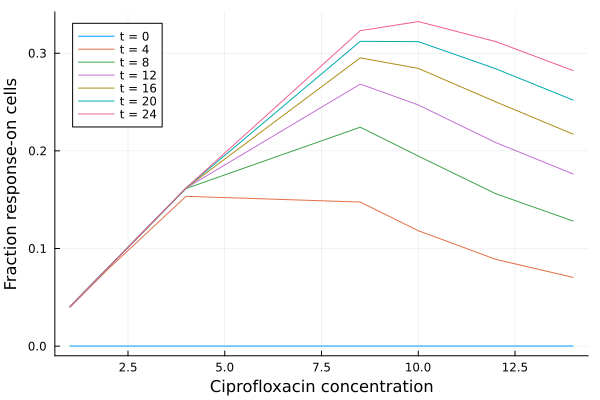

In [23]:
lambda_max = 1.
function pop_dyn(c)
    pop_growth = growth_rate(lambda_max, c, IC50, hill_coeff)
    gamma_off = pop_growth/(1 - c*scaling_factor)
    switching = switching_rate(gamma_off, c, scaling_factor)
    gamma_on = gamma_off*gamma_on_rel
    return pop_growth, switching, gamma_on
end
function pop_sizes(t, c)
    pop_growth, switching, gamma_on = pop_dyn(c)
    n_on = pop_size(t, N0_off, pop_growth, switching, N0_on, gamma_on-delta_on)
    n_off = pop_size(t, N0_off, pop_growth)
    return n_on, n_off
end
function fraction_on(t, c)
    n_on, n_off = pop_sizes(t, c)
    return n_on / (n_on + n_off)
end
P_f = plot(xlab="Ciprofloxacin concentration", ylab="Fraction response-on cells")
for y in 0:4:24
    plot!(C, x -> fraction_on(y, x), lab="t = $y")
end
P_f

(-6.732705536119503, 104.02652656199824)

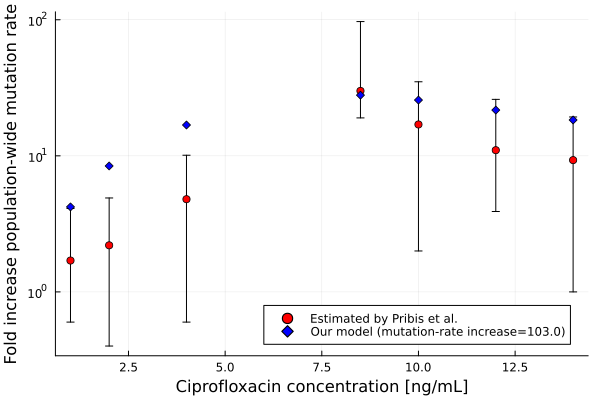

In [41]:
tf = 12
F = [fraction_on(tf, x) for x in C]
i, m = linear_fit(F, M_MLE)
print((i, m))
M = F .* m
mu_inc = m - 1
P_M = plot(ylab="Fold increase population-wide mutation rate", xlab="Ciprofloxacin concentration [ng/mL]", yscale=:log10, legend=:bottomright)
scatter!(C, M_MLE, yerror=(M_lower, M_upper), lab="Estimated by Pribis et al.", c=:red)
scatter!(C, M, lab="Our model (mutation-rate increase=$(round(mu_inc)))", marker=:d, c=:blue)

### Bacteriostatic: antibiotic action through increased death rate

In [43]:
function pop_dyn(c, death)
    pop_growth = growth_rate(lambda_max, c, IC50, hill_coeff)
    switching = switching_rate(gamma_off, c, scaling_factor)
    gamma_on = gamma_off*gamma_on_rel
    return pop_growth, switching, gamma_on
end
function pop_sizes(t, c, death)
    pop_growth, switching, gamma_on = pop_dyn(c, death)
    n_on = pop_size(t, N0_off, pop_growth, switching, N0_on, gamma_on-delta_on)
    n_off = pop_size(t, N0_off, pop_growth)
    return n_on, n_off
end
function fraction_on(t, c, death)
    n_on, n_off = pop_sizes(t, c, death)
    return n_on / (n_on + n_off)
end
P_f = plot(xlab="Ciprofloxacin concentration", ylab="Fraction response-on cells")
for y in 0:4:24
    plot!(C, x -> fraction_on(y, x, true), lab="t = $y")
end
P_f

UndefVarError: UndefVarError: `c` not defined

(2.1214446118648054, 17.539228016704296)

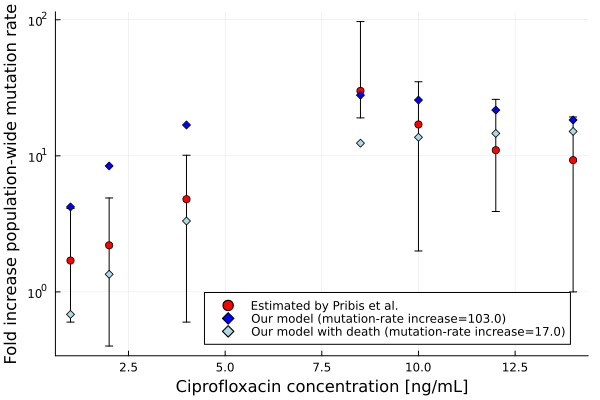

In [42]:
F = [fraction_on(tf, x, true) for x in C]
i, m = linear_fit(F, M_MLE)
print((i, m))
M = F .* m
mu_inc = m - 1
scatter!(P_M, C, M, lab="Our model with death (mutation-rate increase=$(round(mu_inc)))", marker=:d, c=:lightblue)